In [1]:
import networkx as nx
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import random

In [2]:
G = nx.read_gml('GraphMissingEdges.gml')

edges_to_evaluate = pd.read_csv('edgesToEvaluate.csv')

edges_to_evaluate

,linkID,venue1,venue2
0,9,mJ_ucQ2_3hfTsmCcKb-hgw,qXGKYRwCR9SLgLl0g_9o5g
1,135,y19xFolCozaRA-gGmHwkQA,F6c3D1o9Z4Tl6cDorb3WgA
2,434,R1GwW4C1gh2Nmue9K0WYVA,Ul6JwluSTm12PVDIqnNaTg
3,262,zzBa0pQjM1gov00bXjYYXg,3D6Uck9QSdxZKFstf5DGlg
4,383,U2d-meX4sVq0kiqcrpHt1w,vuDL_d3GYAtbvX9EJQqVog
...,...,...,...
495,225,aSb4vkaMh7K2lHhnV2UIag,bQ-sXUqPSr4-iJfB764Nzw
496,288,6p39JCOx1L054G9jM10-5g,xwEYTGJ_82ScbpXcheqqQw
497,348,6WItftahZ9lNFJxfDPSJ0Q,XPmZnhnx0YeN8Xvo7y2xsA
498,187,GUriQoD_GHo6DNJlR1_CrA,1w6_xrdhVD-y-DBYpv0YCQ


In [3]:
indexes = []
data = []
for key, attrs in G.nodes.data():
    indexes.append(key)
    data.append(attrs)

nodes = pd.DataFrame(data, index=indexes)
nodes.head(10)

,longitude,latitude,categories,stars,name,reviewCount
ql0AaBp68ckekxvWOF8xLA,-79.992016,40.438701,"1,362",3.0,Cafe Fifth Ave,20
WHxonk9W_sRLk8cwOoZQqQ,-80.064789,40.436045,"280,566",4.0,Good Fellas Barber Shop,12
P6HDtlj1GSu9UG2Aal2PPg,-79.979840,40.386165,"327,559,107,63,213",3.0,Tightspot Dancewear Center,4
3kUqNxO1rkDDb89GAfyNgw,-79.925404,40.457973,"338,280,247,292,671,546",4.5,Evolve Wellness Spa Shadyside,95
v_pED2nMFPsBGD4Tq2ygBw,-80.001983,40.438355,"407,247,270,645,438,488",2.0,Nova Dental Associates,5
nZDIrGshkfLZf6ImQtAasQ,-80.044442,40.382049,"58,1,341,275,604,248",3.5,The Saloon of Mt Lebanon,60
cqPrr2uDMLP9_cPbIiOSrA,-79.930231,40.456795,"636,1,849,641",2.5,Bagel Factory,42
O1ird5yRyuDFnOmYu90OoA,-79.964218,40.466663,"124,1,208,651,58,275,738",3.5,Round Corner Cantina,353
-UjCvAsvBOr19y8lqPueiQ,-79.917630,40.458928,"791,1",2.5,China Garden,22
zzBa0pQjM1gov00bXjYYXg,-79.981787,40.429373,"706,641,133,344",3.5,South Side BBQ Company Truck,32


In [4]:
categories = pd.read_csv('categories.csv', index_col='CategoryId')

# Second strategy

Use a graph neural network of the Autoencoder (GAE) type. Train it with the features of the nodes.

## Graph initial treatment

In [5]:
from torch import nn
import torch_geometric.transforms as T
import torch.optim as optim
import torch 
from torch_geometric import seed_everything
from torch_geometric.utils.convert import from_networkx

seed_everything(69)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def normalize_coordinates(latitude, longitude):
    min_lat = -90.0
    max_lat = 90.0
    min_lon = -180.0
    max_lon = 180.0

    normalized_lat = (latitude - min_lat) / (max_lat - min_lat)
    normalized_lon = (longitude - min_lon) / (max_lon - min_lon)

    return normalized_lat, normalized_lon

def normalize(val, min_v, max_v):
    return (val - min_v) / (max_v - min_v)

def max_val(G, val, type_of_val):
    return max([type_of_val(d[val]) for _, d in G.nodes.data()])

def min_val(G, val, type_of_val):
    return min([type_of_val(d[val]) for _, d in G.nodes.data()])

def bag_of_categories(node_categories):
    cats = node_categories.split(',')
    boc = np.zeros(len(categories), dtype=np.float32)
    for cat in cats:
        try:
            boc[int(cat)] = 1
        except:
            pass
    return boc

key_to_idx = {}
G_pyg = G.copy()

max_review_count = max_val(G_pyg, 'reviewCount', int)
min_review_count = min_val(G_pyg, 'reviewCount', int)

max_stars = max_val(G_pyg, 'stars', float)
min_stars = min_val(G_pyg, 'stars', float)

max_lat = max_val(G_pyg, 'latitude', float)
min_lat = min_val(G_pyg, 'latitude', float)

max_long = max_val(G_pyg, 'longitude', float)
min_long = min_val(G_pyg, 'longitude', float)

for idx, (k, data) in enumerate(G_pyg.nodes.data()):
    key_to_idx[k] = idx
    G_pyg.nodes[k]['categories'] = bag_of_categories(data['categories'])
    G_pyg.nodes[k]['reviewCount'] = np.array([float(data['reviewCount'])])
    G_pyg.nodes[k]['stars'] = np.array([float(data['stars'])])
    G_pyg.nodes[k]['latitude'] = np.array([float(data['latitude'])])
    G_pyg.nodes[k]['longitude'] = np.array([float(data['longitude'])])
    

## Creating the dataset with torch_geometric

Importing the networkX graph

In [6]:
dataset = from_networkx(G_pyg,
                        group_edge_attrs=all,
                        group_node_attrs=['categories',
                                          'reviewCount',
                                          'stars',
                                          'latitude',
                                          'longitude'])

data = dataset.clone()
data.train_mask = data.val_mask = data.test_mask = None

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(is_undirected=True, add_negative_train_samples=True, split_labels=True),
])

train_data, val_data, test_data = transform(data)
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print(data)
print(test_data)
print(train_data)

Data(edge_index=[2, 37575], name=[4575], x=[4575, 897], edge_attr=[37575, 1])
Data(edge_index=[2, 30386], name=[4575], x=[4575, 897], edge_attr=[30386, 1], pos_edge_label=[3798], pos_edge_label_index=[2, 3798], neg_edge_label=[3798], neg_edge_label_index=[2, 3798])
Data(edge_index=[2, 26588], name=[4575], x=[4575, 897], edge_attr=[26588, 1], pos_edge_label=[13294], pos_edge_label_index=[2, 13294], neg_edge_label=[13294], neg_edge_label_index=[2, 13294])


/opt/conda/lib/python3.10/site-packages/torch_geometric/utils/convert.py:260: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817698971/work/torch/csrc/utils/tensor_new.cpp:201.)
  data[key] = torch.tensor(value)


## Model

A GAE with 2 convolutional layers for encoding. Standard decoding layer (InnerProductDecoder).

AdamW optimizer with lr of 0.001.

In [7]:
from torch_geometric.nn import GAE, GCNConv
import torch.nn as nn

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# params
out_channels = 128
num_features = dataset.num_features

# model - Graph Auto-Encoder (GAE)
model = GAE(GCNEncoder(num_features, out_channels))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

model

GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(897, 256)
    (conv2): GCNConv(256, 128)
  )
  (decoder): InnerProductDecoder()
)

## Training

In [8]:

x = train_data.x.to(device).to(torch.float)
train_pos_edge_index = train_data.pos_edge_label_index.to(device)

epochs = 100

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
        out = model.decode(z, train_pos_edge_index)
        return model.test(z, pos_edge_index, neg_edge_index)

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(val_data.pos_edge_label_index, val_data.neg_edge_label_index)
    print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))   

#Teste
auc, ap = test(test_data.pos_edge_label_index, test_data.neg_edge_label_index)
print('AUC: {:.4f}, AP: {:.4f}'.format( auc, ap))

Epoch: 001, Loss: 1.3859, AUC: 0.8351, AP: 0.8520
Epoch: 002, Loss: 1.3836, AUC: 0.8338, AP: 0.8512
Epoch: 003, Loss: 1.3794, AUC: 0.8333, AP: 0.8507
Epoch: 004, Loss: 1.3726, AUC: 0.8329, AP: 0.8505
Epoch: 005, Loss: 1.3627, AUC: 0.8328, AP: 0.8504
Epoch: 006, Loss: 1.3494, AUC: 0.8323, AP: 0.8501
Epoch: 007, Loss: 1.3329, AUC: 0.8321, AP: 0.8500
Epoch: 008, Loss: 1.3140, AUC: 0.8320, AP: 0.8499
Epoch: 009, Loss: 1.2944, AUC: 0.8320, AP: 0.8499
Epoch: 010, Loss: 1.2797, AUC: 0.8318, AP: 0.8498
Epoch: 011, Loss: 1.2712, AUC: 0.8318, AP: 0.8498
Epoch: 012, Loss: 1.2753, AUC: 0.8318, AP: 0.8498
Epoch: 013, Loss: 1.2824, AUC: 0.8319, AP: 0.8499
Epoch: 014, Loss: 1.2870, AUC: 0.8319, AP: 0.8500
Epoch: 015, Loss: 1.2829, AUC: 0.8320, AP: 0.8500
Epoch: 016, Loss: 1.2759, AUC: 0.8321, AP: 0.8501
Epoch: 017, Loss: 1.2693, AUC: 0.8322, AP: 0.8502
Epoch: 018, Loss: 1.2613, AUC: 0.8324, AP: 0.8504
Epoch: 019, Loss: 1.2591, AUC: 0.8327, AP: 0.8506
Epoch: 020, Loss: 1.2598, AUC: 0.8328, AP: 0.8507


## Inference

Selection of the threshold based on the PR-curve in the set separated for testing. The aim was to maximize the f1-score.

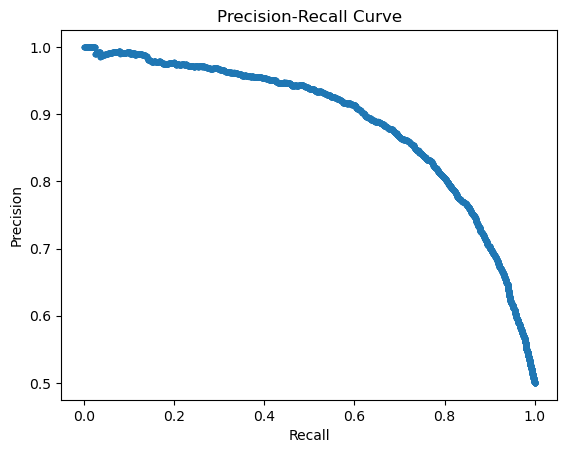

Best thresh: 0.5002791337827313 Best F1: 0.8052592408831556


In [9]:
from sklearn.metrics import precision_recall_curve

# Decode
temp_pos = model.decode(test_data.x, test_data.pos_edge_label_index)
temp_neg = model.decode(test_data.x, test_data.neg_edge_label_index)

# Concat results and labels
results = torch.cat([temp_pos, temp_neg]).cpu()
labels = torch.cat([test_data.pos_edge_label, test_data.neg_edge_label]).cpu()

# compute PR-curve
precision, recall, thresholds = precision_recall_curve(labels, results)
f1_scores = 2*recall*precision/(recall+precision)

# plot da PR-curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# compute best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
threshold = best_threshold
best_f1 = np.max(f1_scores)
print('Best thresh:', best_threshold, 'Best F1:', best_f1)

## Node eval

In [10]:
evaluation_edges_u = []
evaluation_edges_v = []
for _, linkID, u, v in edges_to_evaluate.to_records():
    u_idx = key_to_idx[u]
    v_idx = key_to_idx[v]
    evaluation_edges_u.append(key_to_idx[u])
    evaluation_edges_v.append(key_to_idx[v])

edges_to_evaluate_tensor = torch.tensor([evaluation_edges_u, evaluation_edges_v])

# Decodificando
temp = model.decode(test_data.x, edges_to_evaluate_tensor)

#Atribui 0 ou 1 de acordo com o threshold
preds = (temp > threshold).int()
preds = preds.cpu().detach()

out = pd.concat([edges_to_evaluate, pd.Series(preds, name='link')], axis=1)
out[['linkID', 'link']].to_csv('results_gae.csv', columns=['linkID', 'link'],index=False)

preds.sum()

tensor(286)

## Results obtained on kaggle

- 0.76727 -> best tested result (removed lat and long features)
- 0.75804 -> second best tested result